In [14]:
# David Ouyang 12/5/2019

# Notebook which:
# 1. Downloads weights
# 2. Initializes model and imports weights
# 3. Performs test time evaluation of videos (already preprocessed with ConvertDICOMToAVI.ipynb)

import re
import os, os.path
from os.path import splitext
import pydicom as dicom
import numpy as np
from pydicom.uid import UID, generate_uid
import shutil
from multiprocessing import dummy as multiprocessing
import time
import subprocess
import datetime
from datetime import date
import sys
import cv2
import matplotlib.pyplot as plt
import sys
from shutil import copy
import math
import torch
import torchvision
import pathlib
import tqdm
import scipy 
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
%matplotlib widget

import skimage
import pandas as pd

sys.path.append("..")
import echonet

import wget 

#destinationFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/Output"
destinationFolder = "/athena/sablab/scratch/prj4005/Outputs/pretrained_ef"
#videosFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/a4c-video-dir"
videosFolder = "/athena/sablab/scratch/dataset/echonet/Videos"
#DestinationForWeights = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/EchoNetDynamic-Weights"
DestinationForWeights = "/athena/sablab/scratch/prj4005/Echonet/dynamic/weights"

In [ ]:
# Download model weights

if os.path.exists(DestinationForWeights):
    print("The weights are at", DestinationForWeights)
else:
    print("Creating folder at ", DestinationForWeights, " to store weights")
    os.mkdir(DestinationForWeights)
    
segmentationWeightsURL = 'https://github.com/douyang/EchoNetDynamic/releases/download/v1.0.0/deeplabv3_resnet50_random.pt'
ejectionFractionWeightsURL = 'https://github.com/douyang/EchoNetDynamic/releases/download/v1.0.0/r2plus1d_18_32_2_pretrained.pt'


if not os.path.exists(os.path.join(DestinationForWeights, os.path.basename(segmentationWeightsURL))):
    print("Downloading Segmentation Weights, ", segmentationWeightsURL," to ",os.path.join(DestinationForWeights,os.path.basename(segmentationWeightsURL)))
    filename = wget.download(segmentationWeightsURL, out = DestinationForWeights)
else:
    print("Segmentation Weights already present")
    
if not os.path.exists(os.path.join(DestinationForWeights, os.path.basename(ejectionFractionWeightsURL))):
    print("Downloading EF Weights, ", ejectionFractionWeightsURL," to ",os.path.join(DestinationForWeights,os.path.basename(ejectionFractionWeightsURL)))
    filename = wget.download(ejectionFractionWeightsURL, out = DestinationForWeights)
else:
    print("EF Weights already present")
        


In [ ]:
# Initialize and Run EF model

frames = 32
period = 1 #2
batch_size = 20
model = torchvision.models.video.r2plus1d_18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)



print("loading weights from ", os.path.join(DestinationForWeights, "r2plus1d_18_32_2_pretrained"))

if torch.cuda.is_available():
    print("cuda is available, original weights")
    device = torch.device("cuda")
    model = torch.nn.DataParallel(model)
    model.to(device)
    checkpoint = torch.load(os.path.join(DestinationForWeights, os.path.basename(ejectionFractionWeightsURL)))
    model.load_state_dict(checkpoint['state_dict'])
else:
    print("cuda is not available, cpu weights")
    device = torch.device("cpu")
    checkpoint = torch.load(os.path.join(DestinationForWeights, os.path.basename(ejectionFractionWeightsURL)), map_location = "cpu")
    state_dict_cpu = {k[7:]: v for (k, v) in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict_cpu)


# try some random weights: final_r2+1d_model_regression_EF_sgd_skip1_32frames.pth.tar
# scp ouyangd@arthur2:~/Echo-Tracing-Analysis/final_r2+1d_model_regression_EF_sgd_skip1_32frames.pth.tar "C:\Users\Windows\Dropbox\Echo Research\CodeBase\EchoNetDynamic-Weights"
#Weights = "final_r2+1d_model_regression_EF_sgd_skip1_32frames.pth.tar"


output = os.path.join(destinationFolder, "pretrained_ef.csv")

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder)
print(ds.split, ds.fnames)

mean, std = echonet.utils.get_mean_and_std(ds)

kwargs = {"target_type": "EF",
          "mean": mean,
          "std": std,
          "length": frames,
          "period": period,
          }

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder, **kwargs)

test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 5, shuffle = False, pin_memory=(device.type == "cuda"))
loss, yhat, y = echonet.utils.video.run_epoch(model, test_dataloader,False, None, device, save_all=True)

with open(output, "w") as g:
    for (filename, pred) in zip(ds.fnames, yhat):
        for (i,p) in enumerate(pred):
            g.write("{},{},{:.4f}\n".format(filename, i, p))


In [3]:
output = os.path.join(destinationFolder, "pretrained_ef.csv")


In [ ]:
with open(output, "w+") as g:
    for (filename, pred) in zip(ds.fnames, yhat):
        for (i,p) in enumerate(pred):
            g.write("{},{},{:.4f}\n".format(filename, i, p))


In [ ]:
from IPython.display import display_pdf
filename = "/athena/sablab/scratch/prj4005/Outputs/size/0X105B9EF57DE45DCB.pdf"
with open(filename,"rb") as f:
    display_pdf(f.read(),raw=True)


In [4]:
Raw_data = pd.read_csv('/athena/sablab/scratch/dataset/echonet/FileList.csv', delimiter=',')
Output_data = pd.read_csv(output,header= None, names = ['FileName','FrameNumber','EF'])

In [5]:
Raw_data.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [6]:
Output_data['FileName'] = Output_data['FileName'].str.replace('.avi','')
Output_data.head()


/tmp/ipykernel_256597/3298919079.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Output_data['FileName'] = Output_data['FileName'].str.replace('.avi','')


,FileName,FrameNumber,EF
0,0X100009310A3BD7FC,0,67.5333
1,0X1002E8FBACD08477,0,48.6000
2,0X1005D03EED19C65B,0,61.0651
3,0X10075961BC11C88E,0,49.2817
4,0X10094BA0A028EAC3,0,16.0578


In [7]:
Combined_df = Raw_data.merge(Output_data, on = 'FileName')
Combined_train = Combined_df[Combined_df['Split'] == 'TRAIN']
Combined_val = Combined_df[Combined_df['Split'] == 'VAL']
Combined_test = Combined_df[Combined_df['Split'] == 'TEST']

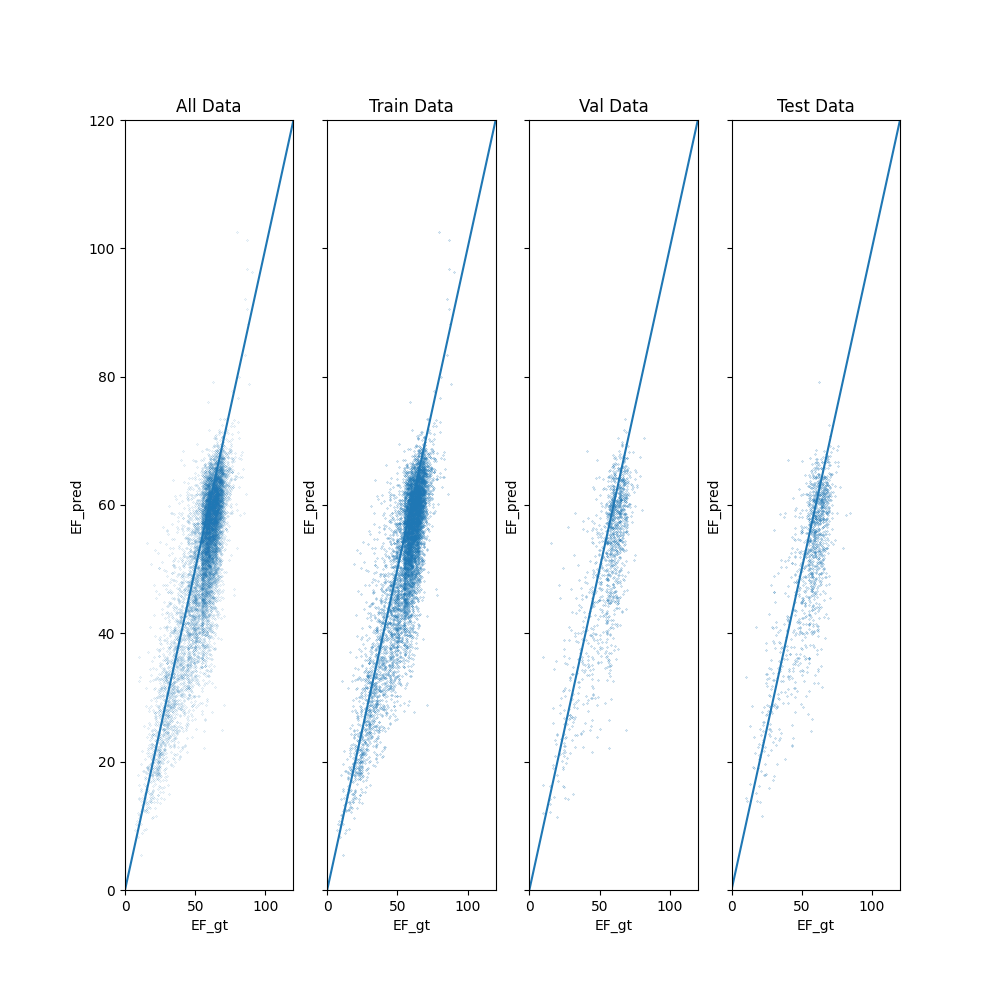

In [8]:
fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(10,10))
ax[0].plot(Combined_df['EF_x'],Combined_df['EF_y'],'o',markersize=0.1)
ax[0].set_xlim(0,120)
ax[0].set_ylim(0,120)
ax[0].set_xlabel('EF_gt')
ax[0].set_ylabel('EF_pred')
ax[0].set_title('All Data')
ax[0].axline((0, 0), slope=1)
ax[1].plot(Combined_train['EF_x'],Combined_train['EF_y'],'o',markersize=0.2)
ax[1].set_xlabel('EF_gt')
ax[1].set_ylabel('EF_pred')
ax[1].set_title('Train Data')
ax[1].axline((0, 0), slope=1)
ax[2].plot(Combined_val['EF_x'],Combined_val['EF_y'],'o',markersize=0.2)
ax[2].set_xlabel('EF_gt')
ax[2].set_ylabel('EF_pred')
ax[2].set_title('Val Data')
ax[2].axline((0, 0), slope=1)
ax[3].plot(Combined_test['EF_x'],Combined_test['EF_y'],'o',markersize=0.2)
ax[3].set_xlabel('EF_gt')
ax[3].set_ylabel('EF_pred')
ax[3].set_title('Test Data')
ax[3].axline((0, 0), slope=1)

In [10]:
mse = mean_squared_error(Combined_df['EF_x'],Combined_df['EF_y'])
mse_train = mean_squared_error(Combined_train['EF_x'],Combined_train['EF_y'])
mse_test = mean_squared_error(Combined_test['EF_x'],Combined_test['EF_y'])
mse_val = mean_squared_error(Combined_val['EF_x'],Combined_val['EF_y'])


In [13]:
print('MSE for all data is: ', (mse))
print('MSE for train data is: ', (mse_train))
print('MSE for test data is: ', mse_test)
print('MSE for val data is: ', mse_val)


MSE for all data is:  67.06466936767939
MSE for train data is:  61.648381191051044
MSE for test data is:  80.73837223679219
MSE for val data is:  84.89950840081096


In [12]:
rmse = np.sqrt(mse)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
rmse_val = np.sqrt(mse_val)
print('RMSE for all data is: ', rmse)
print('RMSE for train data is: ', rmse_train)
print('RMSE for test data is: ', rmse_test)
print('RMSE for val data is: ', rmse_val)


RMSE for all data is:  8.189302129466185
RMSE for train data is:  7.851648310453738
RMSE for test data is:  8.98545336846128
RMSE for val data is:  9.21409292338703


In [17]:
r_squared = r2_score(Combined_df['EF_x'],Combined_df['EF_y'])
r_squared_train = r2_score(Combined_train['EF_x'],Combined_train['EF_y'])
r_squared_test = r2_score(Combined_test['EF_x'],Combined_test['EF_y'])
r_squared_val = r2_score(Combined_val['EF_x'],Combined_val['EF_y'])
r = np.sqrt(r_squared)
r_train = np.sqrt(r_squared_train)
r_test = np.sqrt(r_squared_test)
r_val = np.sqrt(r_squared_val)


In [18]:
print('R2 for all data is: ', r_squared)
print('R2 for train data is: ', r_squared_train)
print('R2 for test data is: ', r_squared_test)
print('R2 for val data is: ', r_squared_val)
print('R for all data is: ', r)
print('R for train data is: ', r_train)
print('R for test data is: ', r_test)
print('R for val data is: ', r_val)


R2 for all data is:  0.5617785925081644
R2 for train data is:  0.5994718725790356
R2 for test data is:  0.45980908166389045
R2 for val data is:  0.43929036068619687
R for all data is:  0.7495189073720319
R for train data is:  0.7742556894069527
R for test data is:  0.6780922368408965
R for val data is:  0.6627898314595637


In [15]:
mae = mean_absolute_error(Combined_df['EF_x'],Combined_df['EF_y'])
mae_train = mean_absolute_error(Combined_train['EF_x'],Combined_train['EF_y'])
mae_test = mean_absolute_error(Combined_test['EF_x'],Combined_test['EF_y'])
mae_val = mean_absolute_error(Combined_val['EF_x'],Combined_val['EF_y'])
print('MAE for all data is: ', mae)
print('MAE for train data is: ', mae_train)
print('MAE for test data is: ', mae_test)
print('MAE for val data is: ', mae_val)


MAE for all data is:  6.365678084978365
MAE for train data is:  6.139651467913731
MAE for test data is:  6.9775559443148
MAE for val data is:  7.069032642443323
